In [1]:
import math
# import random

import gym
import numpy

import jax
# import time
# from numpy import random

# from jax import grad
from jax import grad, jit, vmap
import jax.numpy as np
from jax import random
from jax.ops import index, index_add, index_update


In [2]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [3]:
N = 10

# basisPoints
def bump(x,a,b,c):
    if x<=a:
        return 0
    elif x<=b:
        return (x-a)/(b-a)
    elif x<c:
        return (x-c)/(b-c)
    #else
    return 0

def upslopeBump(x,zero,unit):
    return (x-zero)/(unit-zero)

def downslopeBump(x,zero,unit):
    return (x-unit)/(zero-unit)

# def unitslope()
# def bump(x,a,b,c):
#     if x<=a:
#         return 0
#     elif x<=b:
#         return (x-a)/(b-a)
#     elif x<c:
#         return (x-c)/(b-c)
#     #else
#     return 0


def approx(x,coeffs,basisPoints):
    if x <= basisPoints[0]:
        return coeffs[0]         
    if x > basisPoints[-1]:
        return coeffs[-1]
    for i in range(1,len(basisPoints)):
        if basisPoints[i-1]<x and x<=basisPoints[i]:
            # b=basisPoints[i-1]
            # c=basisPoints[i]
            xout = (
                coeffs[i-1]*downslopeBump(x,basisPoints[i-1],basisPoints[i])
                +  coeffs[i]*upslopeBump(x,basisPoints[i-1],basisPoints[i])
            )
            return xout

@jit
def approx(x,coeffs,basisPoints):
    # Nb = len(basisPoints)
    c1 = coeffs[:-1].reshape(-1,1)
    c2 = coeffs[1:].reshape(-1,1)
    b1 = basisPoints[:-1].reshape(-1,1)
    b2 = basisPoints[1:].reshape(-1,1)
    x = x.reshape(1,-1)
    # return c1,c2,b1,b2,x
    return np.sum(
        (c1 + (c2 - c1)*(x - b1)/(b2 - b1))
        * np.heaviside(x - b1,c1)
        * np.heaviside(b2 - x,c2),
        axis=0
    )

# c1 + (c2 - c1) * (x - b1)/(b2 - b1)
# jit_approx = jit(approx, static_argnums=2)


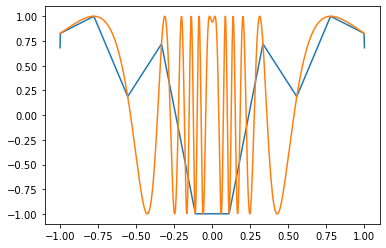

In [4]:
N=10
basisPoints = numpy.linspace(-1,1,N)
f = lambda x: np.sin(1/(x**2+.03))
C = f(basisPoints)
Xs = numpy.linspace(-1,1,977)

# [x for x in basisPoints]
yHat = approx(Xs,C,basisPoints)
plt.plot(Xs,yHat)
plt.plot(Xs,f(Xs))

# [approx(x,C,basisPoints) for x in Xs]

In [4]:
def loss_on_data(data,coeffs,interiorBasisPoints):
    bp = np.hstack([[-1],interiorBasisPoints,[1]])
    return np.sum([(y - approx(x,coeffs,bp))**2 for x,y in data])


# fitting bump basis

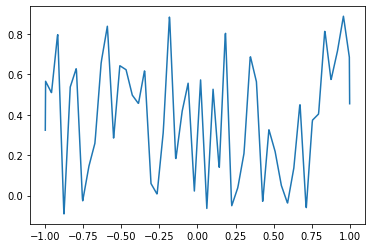

NameError: name 'l' is not defined

In [6]:
N=50
basisPoints = numpy.linspace(-1,1,N)
C = numpy.random.rand(N)-.1
bp = numpy.linspace(-1,1,N)

C_list = [C.copy()]
bp_list = [bp.copy()]

LR_C=0.5
LR_bp=0.01
decay=1
EPOCHS = 1000

batch_size = 100

data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]

def loss(coeffs,interiorBasisPoints):
    return loss_on_data(data, coeffs, interiorBasisPoints)

loss_list=[]

plt.plot(Xs,approx(Xs,C,bp))
plt.show()

for i in range(EPOCHS):
    this_loss = loss(C,bp[1:-1])
    print(f"epoch {i}, loss {l} ", end="\r")
    loss_list.append(this_loss)
    
    g = grad(loss,(0,1))

    g_C, g_bp_int = g(C,bp[1:-1])

    C -= LR_C*(decay**i) * g_C/np.linalg.norm(g_C)
    C_list.append(C.copy())

    bp[1:-1] -= LR_bp*(decay**i) * g_bp_int/np.linalg.norm(g_bp_int)
    bp_list.append(bp.copy())

    # new data batch
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    
plt.plot(Xs,approx(Xs,C,bp))
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(numpy.log10(loss_list))
plt.show()
    

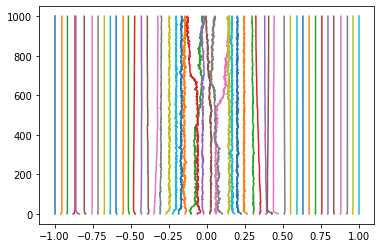

In [263]:
# movement of basis knots
plt.plot(np.vstack(bp_list),range(len(bp_list)))
np.vstack(bp_list).T;
[bp_list[0][i]-bp_list[0][i-1] for i in range(1,len(bp_list[0]))];

In [29]:
r1 = numpy.random.randn(10)
r2 = numpy.random.randn(10)
numpy.dot(r1,r2),np.dot(r1,r2),np.dot(r1,5)

(-0.3960091089583237,
 DeviceArray(-0.3960092, dtype=float32),
 DeviceArray([-3.389011 ,  4.8467054, -2.429453 ,  6.920891 ,  2.7890372,
              -3.389599 , -2.2434013,  0.480597 ,  2.765635 ,  0.6414095],            dtype=float32))

# single layer ReLu perceptron

In [5]:
@jit
def relu(x):
    return np.maximum(0,x)

@jit
def normalize(x):
    return x/np.linalg.norm(x)


@jit
def approx2(x,W1,b1,W2,b2):
    return np.dot(W2, relu(np.dot(W1,x)+b1))+b2

def init_network_params(H):
    # H-> hidden size
    W1 = numpy.random.rand(H)-.5
    b1 = numpy.random.rand(H)-.5
    W2 = numpy.random.rand(H)-.5
    b2 = numpy.random.rand(1)-.5

    return W1,b1,W2,b2

@jit
def loss_2(params,data):
    return np.sum(
        [(y - approx2(x, *params))**2 for x,y in data]
    )

# @jit
# def loss_2(params):
#     return loss_on_data_2(data, params)


In [9]:
Xs = numpy.linspace(-1,1,1000)
params = init_network_params(50)
plt.plot(Xs,[approx2(x,*params) for x in Xs])



TypeError: 'int' object is not subscriptable

In [6]:
def alternate(N,a,b):
    i=0
    out = b
    while i<N:
        i+=1
        out = a if out==b else b
        yield out
        
def alternating_array(N,a,b):
    return numpy.array(list(alternate(N,a,b)))

def checkerboard(N,M):
    return numpy.outer(alternating_array(N,-1.0,1.0),alternating_array(M,1.0,-1.0))


checkerboard(8,4)
# numpy.outer(np.array(alternate(5,-1,1)), np.array(alternate(5,-1,1)), out=None)

array([[-1.,  1., -1.,  1.],
       [ 1., -1.,  1., -1.],
       [-1.,  1., -1.,  1.],
       [ 1., -1.,  1., -1.],
       [-1.,  1., -1.,  1.],
       [ 1., -1.,  1., -1.],
       [-1.,  1., -1.,  1.],
       [ 1., -1.,  1., -1.]])

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 array([ 1., -2.,  2., -2.,  2., -2.,  2., -2.,  2., -2.,  1.]),
 0.0)

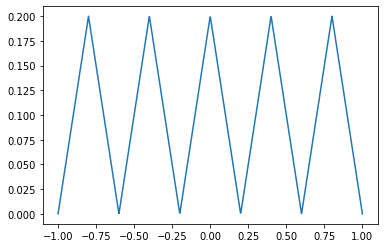

In [10]:
Xs = numpy.linspace(-1,1,1000)
H=11

# these params give a sawtooth
params = (
    numpy.ones(H),
    numpy.linspace(-1,1,H),
    numpy.array([ 1., -2.,  2, -2.,  2., -2.,  2., -2.,  2., -2.,  1.]),
    0.0
)

# params = (
#     alternating_array(H,1,1),
#     numpy.linspace(-1,1,H),
#     alternating_array(H,1,-1),
#     0.0
# )

plt.plot(Xs,[approx2(x,*params) for x in Xs])
params

epoch 999

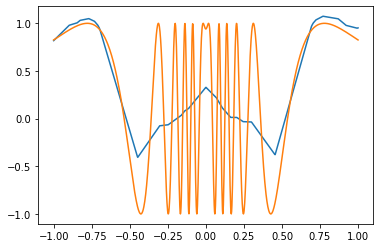

In [11]:
H = 50
# params =  init_network_params(H=50)

params = (
    numpy.ones(H),
    numpy.linspace(-1,1,H),
    alternating_array(H,1.0,-1.0),
    0.0
)

LR =.01
decay=1
EPOCHS = 1000

batch_size = 64

loss_list = []
param_list = []


for i in range(EPOCHS):
    print(f"epoch {i}",end='\r')
    
    g = grad(loss_2)
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]

    g_params = g(params,data)
    params = tuple(
        params[j] - LR*(decay**i) * g_p/np.linalg.norm(g_p)
        for j,g_p in enumerate(g_params)
    )

    loss_list.append(loss_2(params,data))
    param_list.append(params)
    
    

plt.plot(Xs,[approx2(x,*params) for x in Xs])
plt.plot(Xs,f(Xs))
    

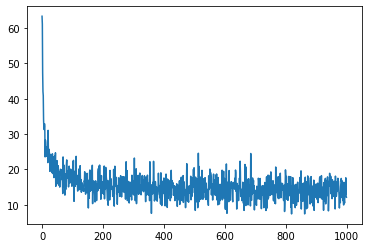

In [12]:
plt.plot(loss_list)

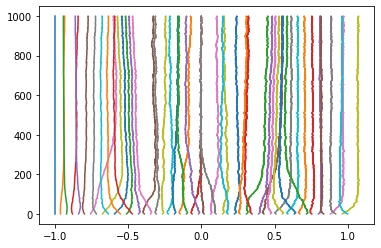

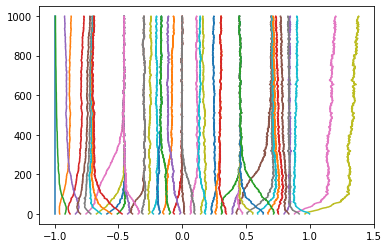

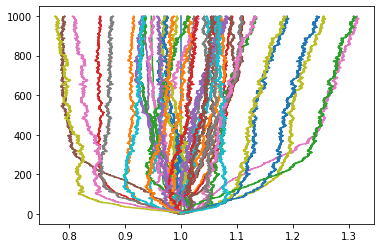

In [14]:
plt.plot(np.vstack([p[1] for p in param_list]),range(len(param_list)))
plt.show()

plt.plot(np.vstack([p[1]/p[0] for p in param_list]),range(len(param_list)))
plt.show()

plt.plot(np.vstack([p[0] for p in param_list]),range(len(param_list)))
plt.show()
# np.vstack(bp_list).T;
# [bp_list[0][i]-bp_list[0][i-1] for i in range(1,len(bp_list[0]))];

In [7]:
def random_layer_params(m, n, scale=1e-2):
    return (
        scale * numpy.random.randn(n, m),
        scale * numpy.random.randn(n,1)
    )

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes,scale=1e-2):
    return [random_layer_params(m, n, scale) for m, n in zip(sizes[:-1], sizes[1:])]

def random_layer_params_unif(m, n, scale=1e-2):
    return (
        scale * 2 * numpy.random.rand(n, m) - 1,
        scale * 2 * numpy.random.rand(n,1) -1
    )

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params_unif(sizes,scale=1):
    return [random_layer_params_unif(m, n, scale) for m, n in zip(sizes[:-1], sizes[1:])]

@jit
def predict(params, x):
    # per-example predictions
    for w, b in params[:-1]:
        x = relu(np.dot(w, x) + b)
    w, b = params[-1]
    return np.dot(w, x) + b
  
params = init_network_params_unif([1,20,1])

plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
N=100
# params =  init_network_params(H=50)

@jit
def loss_3(params, data):
    return np.sum(
        [(y - predict(params,x))**2 for x,y in data]
    )

# def loss(params, data):
#     return loss_on_data(data, predict, params)

@jit
def update(params, data, LR):
    grads = grad(loss_3)(params, data)
    return [
        (w - LR * normalize(dw), b - LR * normalize(db))
        for (w, b), (dw, db) in zip(params, grads)
    ]

NameError: name 'Xs' is not defined

In [ ]:
params

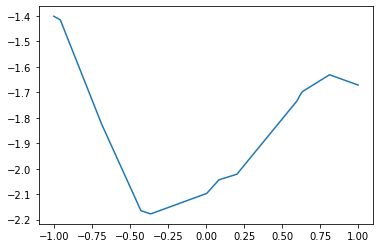

epoch 999, loss 13.377617835998535

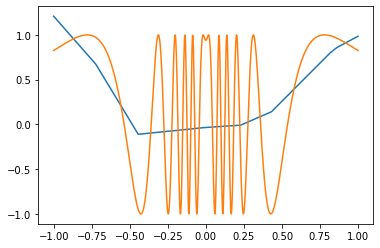

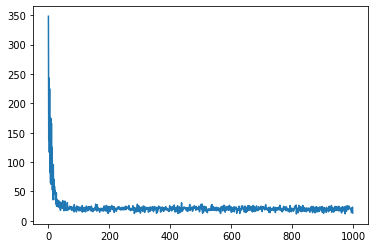

In [143]:
LR = .5
decay=.96
EPOCHS = 1000

batch_size = 64

loss_list = []
param_list = []

H = 50

params = init_network_params([1,H,1])
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.show()

for i in range(EPOCHS):
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    l = loss_3(params,data)
    loss_list.append(l)

    params = update(params,data,LR*decay**i)
    param_list.append(params)
    print(f"epoch {i}, loss {l}",end="\r")
    
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(loss_list)
plt.show()


In [11]:
# params = (
#     numpy.ones(H),
#     numpy.linspace(-1,1,H),
#     alternating_array(H,1,-1),
#     0.0
# )

def conditioned_layer_params(m, n):
    return (
        checkerboard(n,m),
        # numpy.ones((n,m)),
        numpy.linspace(-1,1,n).reshape(n,1)
    )

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params_conditioned(sizes):
    return [conditioned_layer_params(m, n) for m, n in zip(sizes[:-1], sizes[1:])]


# params = init_network_params_conditioned([1,31,1])

# plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
# plt.show()

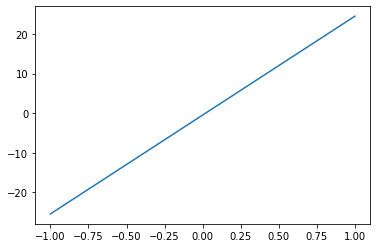

epoch 4999, loss 24.44121551513672

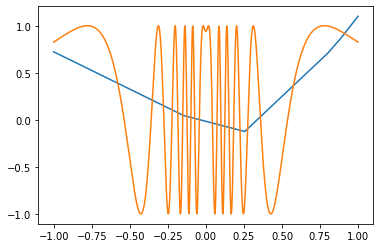

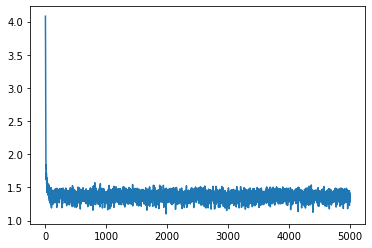

In [175]:
LR = .5
decay=.96
EPOCHS = 5000

batch_size = 100

loss_list = []
param_list = []

H=50

params = init_network_params_conditioned([1,H,1])

plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.show()

for i in range(EPOCHS):
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    l = loss_3(params,data)
    loss_list.append(l)

    params = update(params,data,LR*decay**i)
    param_list.append(params)
    print(f"epoch {i}, loss {l}",end="\r")
    
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(numpy.log10(loss_list))
plt.show()


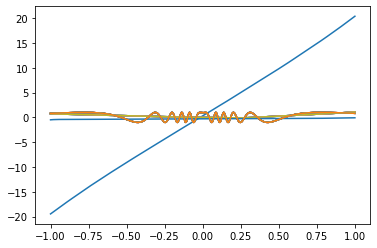

In [188]:
for i in range(0,EPOCHS,int(EPOCHS/10 -1)):
    params = param_list[-i]
    plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
    # plt.title(f"loss: {loss_list[-i]}")
    plt.plot(Xs,f(Xs))
plt.show()


# adding depth

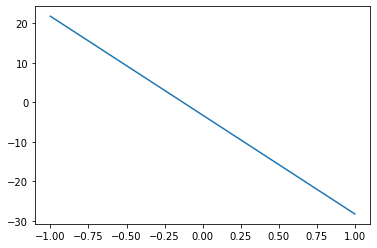

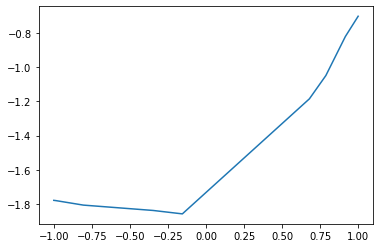

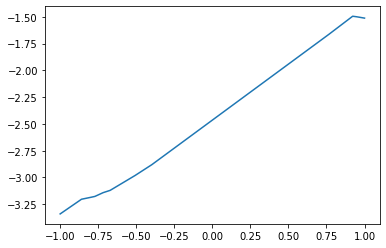

In [12]:

def conditioned_layer_params(m, n):
    return (
        checkerboard(n,m),
        # numpy.ones((n,m)),
        numpy.linspace(-1,1,n).reshape(n,1)
    )

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params_conditioned(sizes):
    return [conditioned_layer_params(m, n) for m, n in zip(sizes[:-1], sizes[1:])]

layers = [1,10,10,1]
params = init_network_params_conditioned(layers)

plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.show()

params = init_network_params_unif(layers)

plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.show()

params = init_network_params_unif(layers)

plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.show()

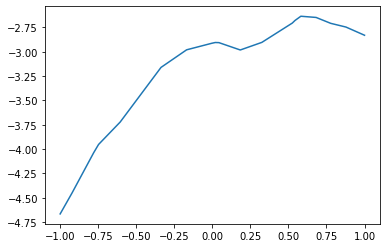

epoch 4999, loss 19.206649780273438

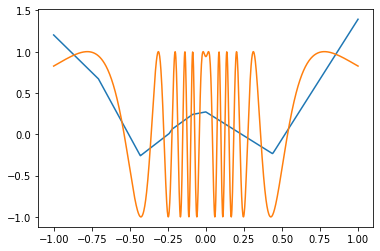

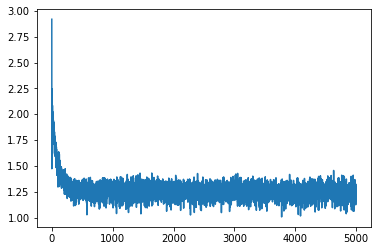

In [208]:
LR = .1
LR_min = .001
decay=.99
EPOCHS = 5000

batch_size = 100

loss_list = []
param_list = []

layers=[1,20,20,1]


params = init_network_params_unif(layers)

Xs = numpy.linspace(-1,1,1000)
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.show()

for i in range(EPOCHS):
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    l = loss_3(params,data)
    loss_list.append(l)

    params = update(params,data, max(LR*decay**i, LR_min))
    param_list.append(params)
    print(f"epoch {i}, loss {l}",end="\r")
    
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(numpy.log10(loss_list))
plt.show()


In [207]:
max(LR*.995**1000,.001)

0.0033269842894159828

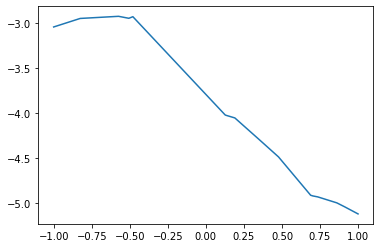

epoch 4999, loss 12.935783386230469

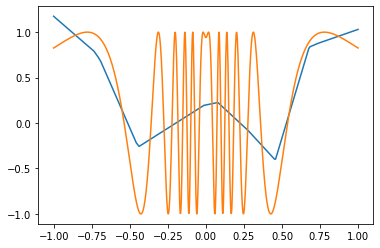

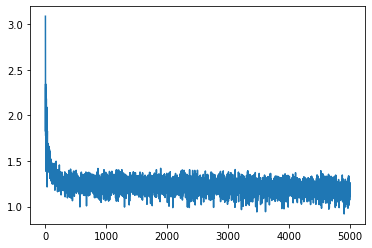

In [264]:
LR = .1
LR_min = .001
decay=.99
EPOCHS = 5000

batch_size = 100

loss_list = []
param_list = []

layers=[1,20,20,20,1]

params = init_network_params_unif(layers)

plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.show()

for i in range(EPOCHS):
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    l = loss_3(params,data)
    loss_list.append(l)

    params = update(params,data, max(LR*decay**i, LR_min))
    param_list.append(params)
    print(f"epoch {i}, loss {l}",end="\r")
    
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(numpy.log10(loss_list))
plt.show()


## He initialization

In [22]:

@jit
def loss(params, data):
    return np.sum(
        [(y - predict(params,x))**2 for x,y in data]
    )

# def loss(params, data):
#     return loss_on_data(data, predict, params)

@jit
def update(params, data, LR):
    grads = grad(loss)(params, data)
    return [
        (w - LR * normalize(dw), b - LR * normalize(db))
        for (w, b), (dw, db) in zip(params, grads)
    ]

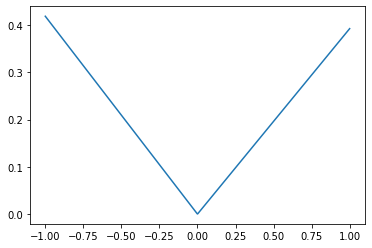

In [20]:

def init_network_params_He(sizes):
    return [(
        numpy.random.randn(n, m)*numpy.sqrt(2/m),
        numpy.zeros((n,1)) 
    ) for m, n in zip(sizes[:-1], sizes[1:])]

layers=[1,300,100,50,1]
params = init_network_params_He(layers)
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])

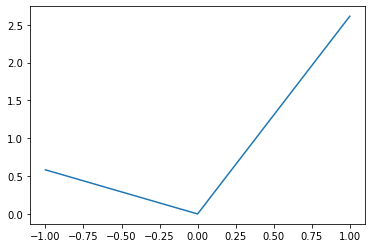

epoch 4998, loss 0.0008194219553843141epoch 4999, loss 0.0007340502343140543

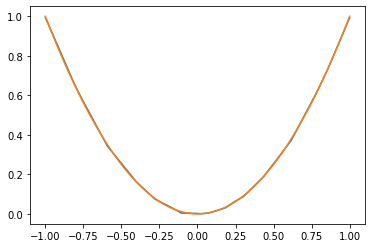

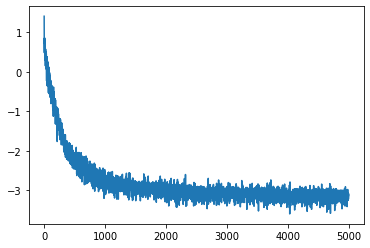

In [23]:
LR = .1
LR_min = .001
decay=.99
EPOCHS = 5000

batch_size = 100

loss_list = []
param_list = []

layers=[1,20,20,1]

########### trivial f
f = lambda x: x**2

params = init_network_params_He(layers)
Xs = numpy.linspace(-1,1,1000)
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.show()

for i in range(EPOCHS):
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    l = loss(params, data)
    loss_list.append(l)

    params = update(params, data, max(LR*decay**i, LR_min))
    param_list.append(params)
    print(f"epoch {i}, loss {l}",end="\r")
    
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(numpy.log10(loss_list))
plt.show()

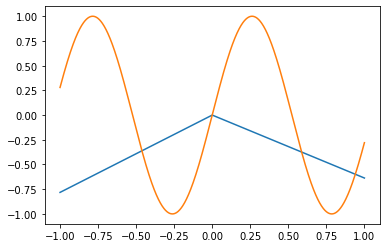

In [26]:
f = lambda x: np.sin(6*x)

params = init_network_params_He(layers)
Xs = numpy.linspace(-1,1,1000)
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()


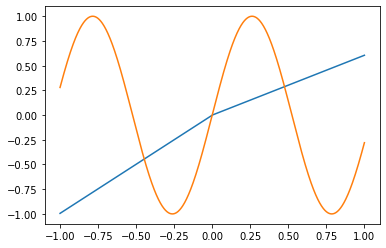

epoch 4999, loss 3.843438148498535

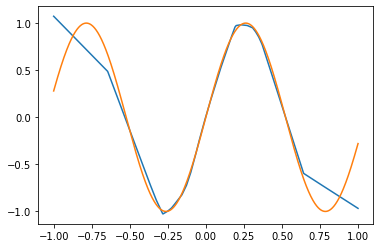

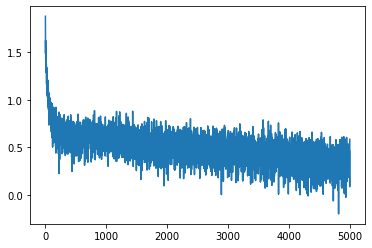

In [33]:
LR = .1
LR_min = .001
decay=.99
EPOCHS = 5000

batch_size = 10000

loss_list = []
param_list = []

layers=[1,40,20,1]

########### trivial f
f = lambda x: np.sin(6*x)

params = init_network_params_He(layers)
Xs = numpy.linspace(-1,1,1000)
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()

for i in range(EPOCHS):
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    l = loss(params, data)
    loss_list.append(l)

    params = update(params, data, max(LR*decay**i, LR_min))
    param_list.append(params)
    print(f"epoch {i}, loss {l}",end="\r")
    
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(numpy.log10(loss_list))
plt.show()

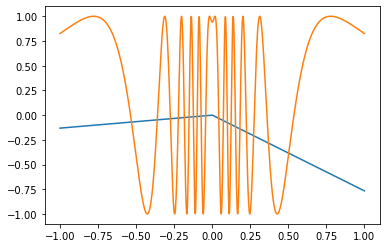

epoch 9999, loss 17.5640811920166

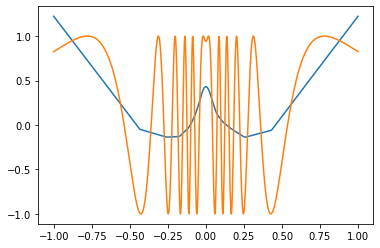

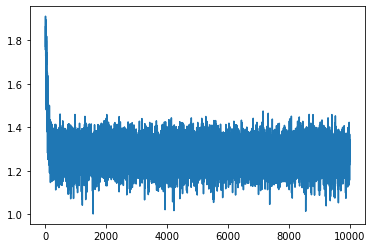

In [32]:
LR = .1
LR_min = .00001
decay=.99
EPOCHS = 10000

batch_size = 10000

loss_list = []
param_list = []

layers=[1,300,200,1]

########### "complicated" f
f = lambda x: np.sin(1/(x**2+.03))

params = init_network_params_He(layers)
Xs = numpy.linspace(-1,1,1000)
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()

for i in range(EPOCHS):
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    l = loss_3(params,data)
    loss_list.append(l)

    params = update(params,data, max(LR*decay**i, LR_min))
    param_list.append(params)
    print(f"epoch {i}, loss {l}",end="\r")
    
plt.plot(Xs,[predict(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(numpy.log10(loss_list))
plt.show()

# Res net

In [292]:
def resnet_random_layer_params(m, n, scale=1e-2):
    return (
        scale * numpy.random.randn(n, m),
        scale * numpy.random.randn(n,1),
        scale * numpy.random.randn(m,n)
    )

def resnet_random_layer_params_unif(m, n, scale=1e-2):
    return (
        scale * 2 * numpy.random.rand(n, m) - 1,
        scale * 2 * numpy.random.rand(n,1) -1,
        scale * 2 * numpy.random.rand(m,n) -1
    )


def resnet_init_network_params(input_size, hidden_sizes, layer_fn, scale):
    return [layer_fn(input_size, m , scale) for m in hidden_sizes]

@jit
def res_net(params, x):
    # per-example predictions
    for w1, b, w2 in params[:-1]:
        x = np.dot(w2, relu(np.dot(w1, x) + b)) - x
    # w, b, _  = params[-1]
    # return np.dot(w, x) + b
    return x
  

@jit
def loss_rn(params, data,):
    return np.sum(
        [(y - res_net(params,x))**2 for x,y in data]
    )

@jit
def update_rn(params, data, LR,):
    grads = grad(loss_rn)(params, data)
    return [
        (
            w1 - LR * normalize(dw1),
            b - LR * normalize(db),
            w2 - LR * normalize(dw2)
        )
        for (w1, b, w2), (dw1, db, dw2) in zip(params, grads)
    ]

In [294]:
res_net(params,.5)

DeviceArray(0.5, dtype=float32)

In [297]:
# resnet_init_network_params(1,[2,2],resnet_random_layer_params_unif,1)
layers = [30,20]
params = resnet_init_network_params(1,layers,resnet_random_layer_params_unif,1)

plt.plot(Xs,[res_net(params,x) for x in Xs])
plt.show()
params


ValueError: x and y can be no greater than 2-D, but have shapes (977,) and (977, 1, 1)

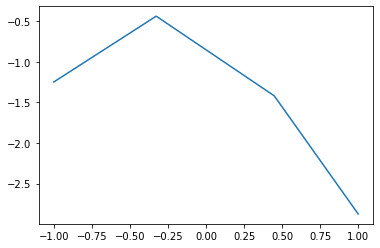

epoch 99, loss 496.34161376953125

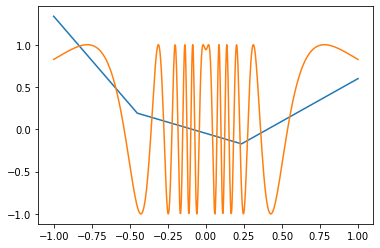

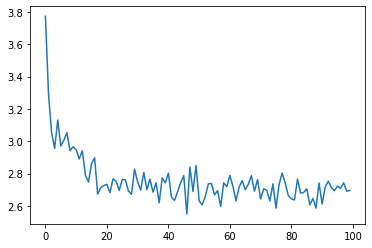

In [284]:
LR = .1
LR_min = .001
decay=.99
EPOCHS = 100

batch_size = 100

loss_list = []
param_list = []

layers=[20,20,20]

params = resnet_init_network_params(1,layers,resnet_random_layer_params_unif,1)

plt.plot(Xs,[res_net(params,x)[0,0] for x in Xs])
plt.show()

for i in range(EPOCHS):
    data = [(x,f(x)) for x in 2*numpy.random.rand(64)-1]
    l = loss_rn(params,data)
    loss_list.append(l)

    params = update_rn(params,data, max(LR*decay**i, LR_min))
    param_list.append(params)
    print(f"epoch {i}, loss {l}",end="\r")
    
plt.plot(Xs,[res_net(params,x)[0,0] for x in Xs])
plt.plot(Xs,f(Xs))
plt.show()
    
plt.plot(numpy.log10(loss_list))
plt.show()
